# Data Survivor

Members:
1. Alexander Patrick Surjono
2. Ramzy Mohammad
3. Retno Dewi Yulianti
4. Stella Linda Cyrilla
5. Wahyu Tri Utomo 

# Scenario
Expected Time of Arrival is the time that is expected of a transport system to arrive at its destination. This term can be used at various scenarios. The term has the same meaning as Estimated Time of Arrival.

During a trip/journey, it is used to convey to the passengers how much time is left before the transport gets to a certain point. In the case of goods delivery, it is used to inform the receiver about the time their good is expected to arrive at their named destination.


In this project, our role is as a data scientist in a company engaged in the transportation sector. We are asked by a stakeholder in our company to find the best model to use to predict ETA.



# Dataset

We use dataset from Website Movement Uber, you can get the data from [here](https://movement.uber.com/explore/toronto/travel-times/query?lat.=43.653226&lng.=-79.4185465&z.=12&lang=en-US&si=113&ti=&ag=neighbourhoods&dt[tpb]=ALL_DAY&dt[wd;]=1,2,3,4,5,6,7&dt[dr][sd]=2020-03-01&dt[dr][ed]=2020-03-31&cd=&sa;=&sdn=).

# 1. Import and install Package

In [7]:
!pip install geopandas

     |████████████████████████████████| 994 kB 8.0 MB/s 
     |████████████████████████████████| 6.6 MB 49.4 MB/s 
     |████████████████████████████████| 15.4 MB 36 kB/s 


In [8]:
import pandas as pd
import geopandas as gpd
import numpy as np
import requests
import shapely
import matplotlib.pyplot as plot
%matplotlib inline

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2 Reading Inputs

Here, we input Toronto Travel time data for January 2020 to March 2020. We consider the weekly aggregate for modeling. 

In [10]:
travel_times = pd.read_csv('/content/drive/MyDrive/SupervisedLearningScriptandMaterial/toronto/Dataset/Travel_Times.csv')
toronto_neighbourhoods_dayly = pd.read_csv('/content/drive/MyDrive/SupervisedLearningScriptandMaterial/toronto/Dataset/toronto-neighbourhoods-2020-1-WeeklyAggregate.csv')

# bnglr_wards_weekly = pd.read_csv('/content/drive/MyDrive/SupervisedLearningScriptandMaterial/bangalore/Dataset/bangalore-wards-2020-1-WeeklyAggregate.csv')
# bnglr_wards_monthly = pd.read_csv('/content/drive/MyDrive/SupervisedLearningScriptandMaterial/bangalore/Dataset/bangalore-wards-2020-1-All-MonthlyAggregate.csv')

# 3. Data Preparation

We would like to use dayly travel time average for modeling. Let's use this first, then you can play around with other time-series data!

In [11]:
toronto_neighbourhoods_dayly

,sourceid,dstid,dow,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time
0,129,47,2,1556.85,537.31,1476.10,1.38
1,80,89,2,416.18,154.30,394.96,1.37
2,128,86,2,132.03,85.68,107.52,2.08
3,129,76,2,763.53,224.10,731.70,1.35
4,35,77,1,1700.19,610.52,1609.98,1.37
...,...,...,...,...,...,...,...
125087,34,125,7,575.24,183.47,551.97,1.32
125088,92,103,3,1964.66,533.35,1896.40,1.30
125089,33,135,7,1807.29,403.37,1766.86,1.23
125090,136,9,1,967.56,270.94,934.87,1.29


In [12]:
travel_times.head()

,Origin Movement ID,Origin Display Name,Destination Movement ID,Destination Display Name,Date Range,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds)
0,113,"Saint Basil Lane, Bay Cloverhill, Old Toronto,...",1,"York University Busway, York University Height...","3/1/2020 - 3/31/2020, Every day, Daily Average",1870,1405,2487
1,113,"Saint Basil Lane, Bay Cloverhill, Old Toronto,...",2,"0 Hambly Avenue, The Beach, Old Toronto, Toronto","3/1/2020 - 3/31/2020, Every day, Daily Average",886,635,1235
2,113,"Saint Basil Lane, Bay Cloverhill, Old Toronto,...",3,"3400 Kingston Road, Scarborough Village, Scarb...","3/1/2020 - 3/31/2020, Every day, Daily Average",2090,1649,2648
3,113,"Saint Basil Lane, Bay Cloverhill, Old Toronto,...",4,"100 Dunn Avenue, Parkdale, Old Toronto, Toronto","3/1/2020 - 3/31/2020, Every day, Daily Average",815,530,1252
4,113,"Saint Basil Lane, Bay Cloverhill, Old Toronto,...",5,"0 Carlaw Avenue, Leslieville, Old Toronto, Tor...","3/1/2020 - 3/31/2020, Every day, Daily Average",540,372,782


In [13]:
toronto_neighbourhoods_dayly

,sourceid,dstid,dow,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time
0,129,47,2,1556.85,537.31,1476.10,1.38
1,80,89,2,416.18,154.30,394.96,1.37
2,128,86,2,132.03,85.68,107.52,2.08
3,129,76,2,763.53,224.10,731.70,1.35
4,35,77,1,1700.19,610.52,1609.98,1.37
...,...,...,...,...,...,...,...
125087,34,125,7,575.24,183.47,551.97,1.32
125088,92,103,3,1964.66,533.35,1896.40,1.30
125089,33,135,7,1807.29,403.37,1766.86,1.23
125090,136,9,1,967.56,270.94,934.87,1.29


Text(0, 0.5, 'Mean travel time in mins')

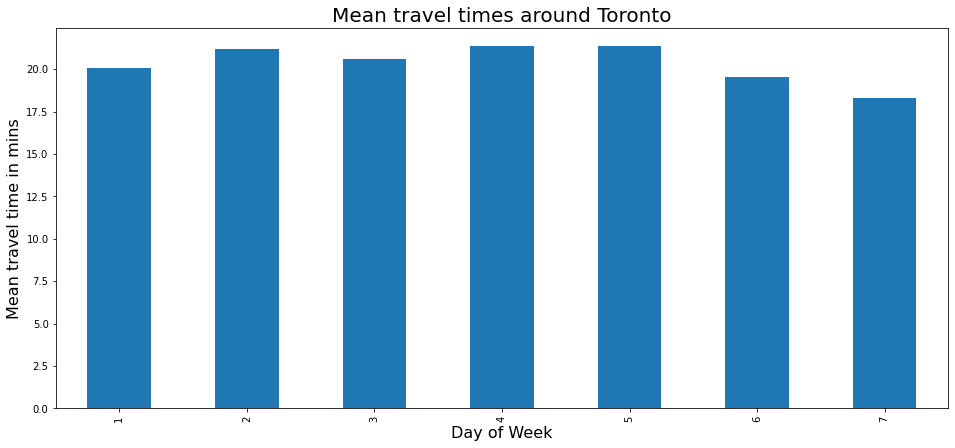

In [14]:
mean_travel_time_by_day_of_week = toronto_neighbourhoods_dayly.groupby('dow')['mean_travel_time'].mean()/60
plt = mean_travel_time_by_day_of_week.plot(kind="bar", figsize=(16,7))
plt.set_title('Mean travel times around Toronto', fontsize=20)
plt.set_xlabel('Day of Week', fontsize = 16)
plt.set_ylabel('Mean travel time in mins', fontsize = 16)

Seen from the graph above, the high mean travel time occurs on weekdays, namely days 1, 2, 3, 4, 5. This is due to the dense mobility of workers.

Text(0, 0.5, 'Std Dev off travel time in mins')

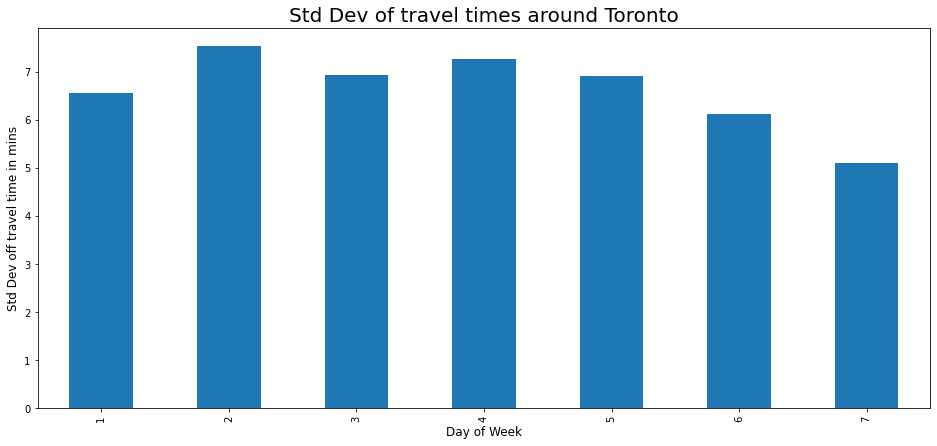

In [15]:
std_dev_travel_time_by_day_of_week = toronto_neighbourhoods_dayly.groupby('dow')['standard_deviation_travel_time'].mean()/60
plt = std_dev_travel_time_by_day_of_week.plot(kind="bar", figsize = (16,7))
plt.set_title('Std Dev of travel times around Toronto', fontsize =20)
plt.set_xlabel('Day of Week', fontsize = 12)
plt.set_ylabel('Std Dev off travel time in mins', fontsize = 12)

## 3.1 (Map of Toronto City)

In [16]:
toronto = gpd.read_file('/content/drive/MyDrive/SupervisedLearningScriptandMaterial/toronto/Dataset/toronto_neighbourhoods.json')

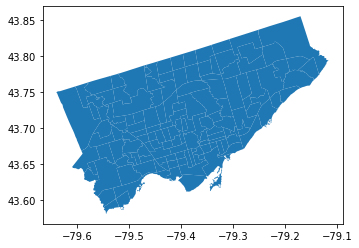

In [17]:
toronto.plot()

Seen from the graph above is a map of the Toronto city.

In [18]:
Seen from the graph above is a map of the city of Toronto

SyntaxError: ignored

In [19]:
toronto.head()

,MOVEMENT_ID,DISPLAY_NAME,geometry
0,1,"York University Busway, York University Height...","MULTIPOLYGON (((-79.50529 43.75987, -79.50488 ..."
1,2,"0 Hambly Avenue, The Beach, Old Toronto, Toronto","MULTIPOLYGON (((-79.31485 43.66674, -79.31356 ..."
2,3,"3400 Kingston Road, Scarborough Village, Scarb...","MULTIPOLYGON (((-79.21397 43.72676, -79.21400 ..."
3,4,"100 Dunn Avenue, Parkdale, Old Toronto, Toronto","MULTIPOLYGON (((-79.42777 43.62979, -79.42948 ..."
4,5,"0 Carlaw Avenue, Leslieville, Old Toronto, Tor...","MULTIPOLYGON (((-79.32868 43.64745, -79.32867 ..."


### 3.1.1 Picking centroids to represent an area

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


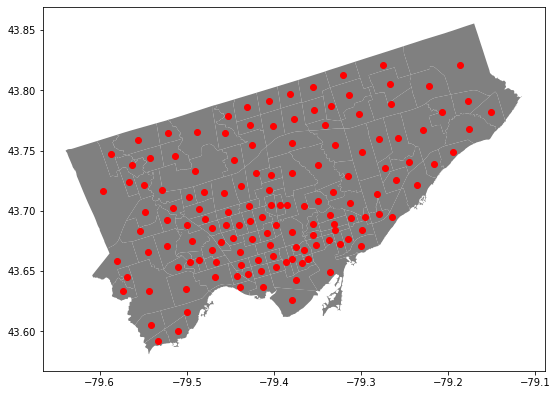

In [20]:
toronto = toronto.drop(columns=['MOVEMENT_ID'])
toronto_c = toronto.copy()
toronto_c.geometry = toronto_c['geometry'].centroid
fig, ax = plot.subplots(figsize=(9,9))
toronto.plot(color='grey',ax=ax)
toronto_c.plot(color='red',ax=ax)

In [21]:
travel_times.head(1)

,Origin Movement ID,Origin Display Name,Destination Movement ID,Destination Display Name,Date Range,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds)
0,113,"Saint Basil Lane, Bay Cloverhill, Old Toronto,...",1,"York University Busway, York University Height...","3/1/2020 - 3/31/2020, Every day, Daily Average",1870,1405,2487


In [22]:
id_to_dest = travel_times[['Destination Movement ID', 'Destination Display Name']]
id_to_dest.columns = ['id', 'name']
id_to_dest.head()

,id,name
0,1,"York University Busway, York University Height..."
1,2,"0 Hambly Avenue, The Beach, Old Toronto, Toronto"
2,3,"3400 Kingston Road, Scarborough Village, Scarb..."
3,4,"100 Dunn Avenue, Parkdale, Old Toronto, Toronto"
4,5,"0 Carlaw Avenue, Leslieville, Old Toronto, Tor..."


### 3.1.2 Get some random points from each neighbor to diversify representation

In [23]:
from shapely.geometry import Point
import random

# The number of rows with random points to be created corresponding to each row in source df
number = 3

def random_points_in_polygon(number, polygon):
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    i= 0
    while i < number:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if polygon.contains(point):
            points.append(point)
            i += 1
    return points

def diversify_geo_data(df):
    new_df = gpd.GeoDataFrame()
    common_columns = df.columns
    common_columns.tolist().remove('geometry')
    for row in df.itertuples():
        points = random_points_in_polygon(number, row.geometry)
        for point in points:
            tmp = gpd.GeoDataFrame(columns=df.columns, data=[list(row[1:2]) + [point]])
            new_df = new_df.append(tmp, ignore_index=True)
    return new_df
            

diversified_points = diversify_geo_data(toronto)
diversified_points.sample(5)

,DISPLAY_NAME,geometry
67,"500 Manning Avenue, Palmerston, Old Toronto, T...",POINT (-79.41684 43.66083)
168,"0 Chieftain Crescent, St. Andrew - Windfields,...",POINT (-79.36786 43.75256)
315,"0 Ridgevale Drive, Englemount - Lawrence, Nort...",POINT (-79.43741 43.70792)
13,"0 Carlaw Avenue, Leslieville, Old Toronto, Tor...",POINT (-79.35434 43.64083)
397,"0 Ash Crescent, Long Branch, Etobicoke, Toronto",POINT (-79.52687 43.59582)


In [24]:
diversified_points.shape

(423, 2)

In [25]:
toronto.head()

,DISPLAY_NAME,geometry
0,"York University Busway, York University Height...","MULTIPOLYGON (((-79.50529 43.75987, -79.50488 ..."
1,"0 Hambly Avenue, The Beach, Old Toronto, Toronto","MULTIPOLYGON (((-79.31485 43.66674, -79.31356 ..."
2,"3400 Kingston Road, Scarborough Village, Scarb...","MULTIPOLYGON (((-79.21397 43.72676, -79.21400 ..."
3,"100 Dunn Avenue, Parkdale, Old Toronto, Toronto","MULTIPOLYGON (((-79.42777 43.62979, -79.42948 ..."
4,"0 Carlaw Avenue, Leslieville, Old Toronto, Tor...","MULTIPOLYGON (((-79.32868 43.64745, -79.32867 ..."


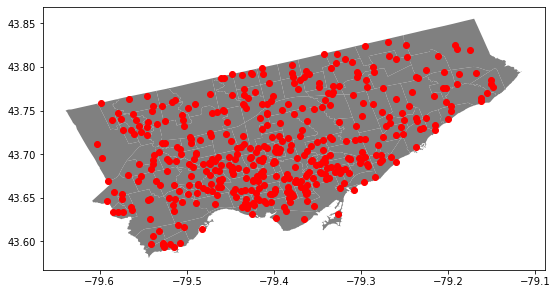

In [26]:
fig, ax = plot.subplots(figsize=(9,9))
toronto.plot(color='grey',ax=ax)
diversified_points.plot(color='red',ax=ax)

## 3.2 Cleaning up data for analysis
Got source and destination data and removed unneeded columns like geometric_mean_travel_time and geometric_standard_deviation_travel_time.

In [27]:
id_to_dest

,id,name
0,1,"York University Busway, York University Height..."
1,2,"0 Hambly Avenue, The Beach, Old Toronto, Toronto"
2,3,"3400 Kingston Road, Scarborough Village, Scarb..."
3,4,"100 Dunn Avenue, Parkdale, Old Toronto, Toronto"
4,5,"0 Carlaw Avenue, Leslieville, Old Toronto, Tor..."
...,...,...
136,137,"0 Treerun Avenue, Milliken, Scarborough, Toronto"
137,138,"0 Livonia Place, Morningside, Scarborough, Tor..."
138,139,"0 Rolph Road, Leaside, East York, Toronto"
139,140,"900 York Beltline Trail, Briar Hill - Belgravi..."


In [28]:
toronto_neighbourhoods_dayly.head()

,sourceid,dstid,dow,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time
0,129,47,2,1556.85,537.31,1476.10,1.38
1,80,89,2,416.18,154.30,394.96,1.37
2,128,86,2,132.03,85.68,107.52,2.08
3,129,76,2,763.53,224.10,731.70,1.35
4,35,77,1,1700.19,610.52,1609.98,1.37


In [29]:
time_df = pd.merge(toronto_neighbourhoods_dayly, id_to_dest, left_on=['sourceid'], right_on=['id'], how='inner')
time_df = time_df.drop(columns=['id', 'geometric_mean_travel_time', 'geometric_standard_deviation_travel_time'])
time_df = time_df.rename(columns={'name': 'Source Name'})
time_df = pd.merge(time_df, id_to_dest, left_on=['dstid'], right_on=['id'], how='inner')
time_df = time_df.drop(columns=['id'])
time_df = time_df.rename(columns={'name': 'Destination Name'})
time_df = time_df.sort_values(by=['sourceid', 'dstid', 'dow'])
time_df.head(5)

,sourceid,dstid,dow,mean_travel_time,standard_deviation_travel_time,Source Name,Destination Name
110846,1,1,1,255.19,146.62,"York University Busway, York University Height...","York University Busway, York University Height..."
110850,1,1,2,247.13,134.92,"York University Busway, York University Height...","York University Busway, York University Height..."
110845,1,1,3,275.46,165.36,"York University Busway, York University Height...","York University Busway, York University Height..."
110848,1,1,4,276.60,157.16,"York University Busway, York University Height...","York University Busway, York University Height..."
110844,1,1,5,274.65,162.75,"York University Busway, York University Height...","York University Busway, York University Height..."


In [30]:
full_toronto = toronto_c.append(diversified_points, ignore_index=True)
full_toronto.shape

(564, 2)

In [31]:
full_toronto.head()

,DISPLAY_NAME,geometry
0,"York University Busway, York University Height...",POINT (-79.48888 43.76574)
1,"0 Hambly Avenue, The Beach, Old Toronto, Toronto",POINT (-79.29960 43.67105)
2,"3400 Kingston Road, Scarborough Village, Scarb...",POINT (-79.21681 43.73865)
3,"100 Dunn Avenue, Parkdale, Old Toronto, Toronto",POINT (-79.43934 43.63670)
4,"0 Carlaw Avenue, Leslieville, Old Toronto, Tor...",POINT (-79.33565 43.64929)


In [32]:
time_df2 = pd.merge(time_df, full_toronto, left_on=['Source Name'], right_on=['DISPLAY_NAME'], how='inner')
time_df2 = time_df2.drop(columns=['DISPLAY_NAME'])
time_df2 = time_df2.rename(columns = {'WARD_NAME': 'Source Ward Name', 'geometry': 'Source Geometry'})
time_df2.shape

(500368, 8)

In [33]:
time_df2 = pd.merge(time_df2, full_toronto, left_on=['Destination Name'], right_on=['DISPLAY_NAME'], how='inner')
time_df2 = time_df2.drop(columns=['DISPLAY_NAME'])
time_df2 = time_df2.rename(columns = {'WARD_NAME': 'Destination Ward Name', 'geometry': 'Destination Geometry'})
time_df2.sample(3)

,sourceid,dstid,dow,mean_travel_time,standard_deviation_travel_time,Source Name,Destination Name,Source Geometry,Destination Geometry
585710,56,45,3,983.80,469.64,"5300 Dundas Street West, Islington - City Cent...","0 Apex Road, Yorkdale, North York, Toronto",POINT (-79.54257 43.64880),POINT (-79.44986 43.71549)
628796,58,48,2,1274.25,794.01,"0 Habitant Drive, Emery, North York, Toronto","0 Grenoble Drive, Flemingdon Park, North York,...",POINT (-79.54468 43.73645),POINT (-79.33265 43.71593)
569798,54,44,2,1249.40,518.14,"500 Mortimer Avenue, Woodbine Heights, East Yo...","200 Johnston Avenue, Lansing, North York, Toronto",POINT (-79.34163 43.69077),POINT (-79.43248 43.75248)


In [34]:
time_df2.shape

(2001472, 9)

In [35]:
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

import os.path
def file_exists(filename):
    return os.path.exists(filename)

output_path = '/content/drive/MyDrive/SupervisedLearningScriptandMaterial/toronto/Output2/'

In [36]:
import geopy.distance

def calc_distance(x):
    src_point = (x['Source Geometry'].y, x['Source Geometry'].x)
    dest_point = (x['Destination Geometry'].y, x['Destination Geometry'].x)
    return geopy.distance.geodesic(src_point, dest_point).kilometers

filename = 'Df_for_modelling.bin'
path = output_path + filename

if file_exists(path):
    # skip to next section since the results here are already precalculated
    pass
else:
    print('Creating distance file')
    time_df2['Geodesic Distance'] = time_df2.apply(func = calc_distance, axis=1)
    df = time_df2

Creating distance file


In [37]:
filename = 'Df_for_modelling.bin'
path = output_path + filename
if file_exists(path):
    with open(path, 'rb') as file:
        final_df = pickle.load(file)
else:
    print('Creating final df file')
    final_df = df.copy()
    final_df['Source lat'] = final_df['Source Geometry'].apply(lambda pt: float(pt.y))
    final_df['Source long'] = final_df['Source Geometry'].apply(lambda pt: float(pt.x))
    final_df['Dest lat'] = final_df['Destination Geometry'].apply(lambda pt: float(pt.y))
    final_df['Dest long'] = final_df['Destination Geometry'].apply(lambda pt: float(pt.x))

    
features = ['Source lat', 'Source long', 'Dest lat', 'Dest long', 'dow', 'Geodesic Distance']
outcome = ['mean_travel_time']
final_df = final_df[features + outcome]

try:
    save_object(final_df, filename)
except:
    pass
  

Creating final df file


In [38]:
final_df.shape

(2001472, 7)

In [39]:
final_df.head(8)

,Source lat,Source long,Dest lat,Dest long,dow,Geodesic Distance,mean_travel_time
0,43.765737,-79.488883,43.765737,-79.488883,1,0.000000,255.19
1,43.765737,-79.488883,43.753307,-79.498861,1,1.597879,255.19
2,43.765737,-79.488883,43.757189,-79.490702,1,0.960981,255.19
3,43.765737,-79.488883,43.768707,-79.472995,1,1.321123,255.19
4,43.753307,-79.498861,43.765737,-79.488883,1,1.597879,255.19
5,43.753307,-79.498861,43.753307,-79.498861,1,0.000000,255.19
6,43.753307,-79.498861,43.757189,-79.490702,1,0.786042,255.19
7,43.753307,-79.498861,43.768707,-79.472995,1,2.695593,255.19


# 4.Modeling
Model without eval set

In [40]:
X = final_df[features]
y = final_df[outcome]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

## 4.1 Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
filename = 'RF_model_5.bin'
path = output_path + filename
if file_exists(path):
    with open(path, 'rb') as file:
        my_model = pickle.load(file)
else:
    my_model = xgb.XGBRegressor(n_estimators= 200, min_samples_leaf=1, max_features= 0.8, max_depth= 20)
    my_model.fit(X_train, y_train,verbose=False)
    
try:    
    save_object(X_train, output_path + 'train_set_x.bin')
    save_object(y_train, output_path + 'train_set_y.bin')
    save_object(X_test, output_path + 'test_set_x.bin')
    save_object(y_test, output_path + 'test_set_y.bin')
    save_object(my_model, output_path + filename)
except:
    pass

[08:24:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Metrics Calculation

In [ ]:
predictions = my_model.predict(X_test)

from sklearn import metrics

r2 = metrics.r2_score(y_test, predictions)
print('R2: {}\n'.format(r2))

mse = metrics.mean_squared_error(y_test, predictions)
print('MSE: {}\n'.format(mse))

print('RMSE: {}\n'.format(np.sqrt(mse)))

mae = metrics.mean_absolute_error(y_test, predictions)
print('MAE: {}\n'.format(mae))

R2: 0.9962675173602626

MSE: 1020.3194282169444

RMSE: 31.942439296599506

MAE: 21.356577115632376



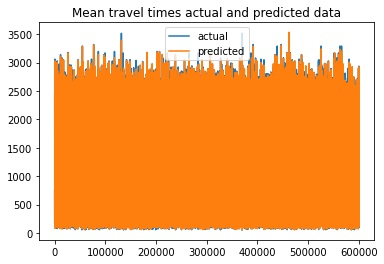

In [ ]:
x_ax = range(len(y_test))
plot.plot(x_ax, y_test, label="actual")
plot.plot(x_ax, predictions, label="predicted")

plot.title("Mean travel times actual and predicted data")

plot.legend()
plot.show()

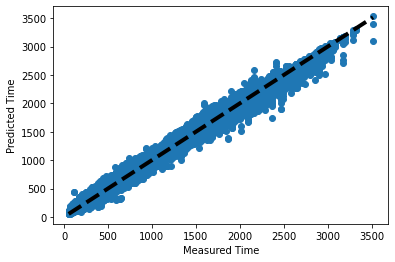

In [ ]:
fig, ax = plot.subplots()
ax.scatter(y_test, predictions)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured Time')
ax.set_ylabel('Predicted Time')
plot.show()

## 4.1.1 Live Testing

In [ ]:
features = ['Source lat', 'Source long', 'Dest lat', 'Dest long', 'dow', 'Geodesic Distance']
outcome = ['mean_travel_time']

def get_distance(lat1, long1, lat2, long2):
    src_point = (lat1, long1)
    dest_point = (lat2, long2)
    return geopy.distance.geodesic(src_point, dest_point).kilometers

def prepare_df(lat1, long1, lat2, long2, hod):
    distance = get_distance(lat1, long1, lat2, long2)
    return pd.DataFrame(columns = ['Source lat', 'Source long', 'Dest lat', 'Dest long', 'dow', 'Geodesic Distance'],
                 data = [[lat1, long1, lat2, long2, dow, distance]])
    
def predict(df):
    return my_model.predict(df[features])

In [ ]:
lat1 = 13.002385
long1 = 77.568491
lat2 = 13.061071
long2 = 77.597371
dow = 10

df = prepare_df(lat1, long1, lat2, long2, dow)
predict(df)

array([580.499], dtype=float32)

## 4.2 XGBOOST Regressor

In [ ]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
filename = 'XGB_model_1.bin'
path = output_path + filename
if file_exists(path):
    with open(path, 'rb') as file:
        my_model = pickle.load(file)
else:
    my_model_3 = xgb.XGBRegressor(colsample_bytree= 0.4609118417511593, learning_rate= 0.13147737226053333, max_depth= 9, n_estimators= 107, reg_alpha= 0.36568523340889936, reg_lambda= 0.0024257956486115864, subsample= 0.775773831943148)
    my_model_3.fit(X_train, y_train,verbose=False)
    
try:    
    save_object(X_train, output_path + 'train_set_x.bin')
    save_object(y_train, output_path + 'train_set_y.bin')
    save_object(X_test, output_path + 'test_set_x.bin')
    save_object(y_test, output_path + 'test_set_y.bin')
    save_object(my_model, output_path + filename)
except:
    pass

[08:41:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Metrics Calculation

In [ ]:
predictions_1 = my_model_3.predict(X_test)

from sklearn import metrics

r2 = metrics.r2_score(y_test, predictions_1)
print('R2: {}\n'.format(r2))

mse = metrics.mean_squared_error(y_test, predictions_1)
print('MSE: {}\n'.format(mse))

print('RMSE: {}\n'.format(np.sqrt(mse)))

mae = metrics.mean_absolute_error(y_test, predictions_1)
print('MAE: {}\n'.format(mae))

R2: 0.8985488993776289

MSE: 27732.889599261613

RMSE: 166.5319476835049

MAE: 130.12750651423877



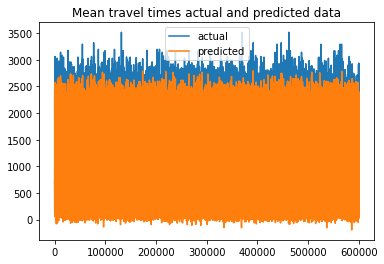

In [ ]:
x_ax = range(len(y_test))
plot.plot(x_ax, y_test, label="actual")
plot.plot(x_ax, predictions_1, label="predicted")

plot.title("Mean travel times actual and predicted data")

plot.legend()
plot.show()

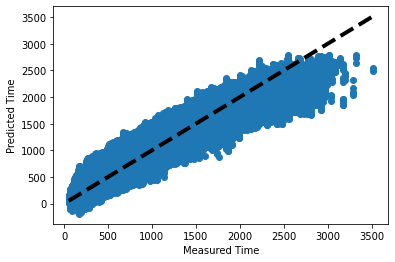

In [ ]:
fig, ax = plot.subplots()
ax.scatter(y_test, predictions_1)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured Time')
ax.set_ylabel('Predicted Time')
plot.show()

### 4.2.1 Live Testing

In [ ]:
features = ['Source lat', 'Source long', 'Dest lat', 'Dest long', 'dow', 'Geodesic Distance']
outcome = ['mean_travel_time']

def get_distance(lat1, long1, lat2, long2):
    src_point = (lat1, long1)
    dest_point = (lat2, long2)
    return geopy.distance.geodesic(src_point, dest_point).kilometers

def prepare_df(lat1, long1, lat2, long2, hod):
    distance = get_distance(lat1, long1, lat2, long2)
    return pd.DataFrame(columns = ['Source lat', 'Source long', 'Dest lat', 'Dest long', 'dow', 'Geodesic Distance'],
                 data = [[lat1, long1, lat2, long2, dow, distance]])
    
def predict(df):
    return my_model_3.predict(df[features])

In [ ]:
lat1 = 13.002385
long1 = 77.568491
lat2 = 13.061071
long2 = 77.597371
dow = 10

df = prepare_df(lat1, long1, lat2, long2, dow)
predict(df)

array([977.40283], dtype=float32)

## 4.3 GradientBoosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
filename = 'GradBoost_model_2.bin'
path = output_path + filename
if file_exists(path):
    with open(path, 'rb') as file:
        my_model = pickle.load(file)
else:
    
    my_model_6 = reg = GradientBoostingRegressor(max_depth=9, learning_rate=0.05, random_state=0)
    my_model_6.fit(X_train, y_train)
    
try:    
    save_object(X_train, output_path + 'train_set_x.bin')
    save_object(y_train, output_path + 'train_set_y.bin')
    save_object(X_test, output_path + 'test_set_x.bin')
    save_object(y_test, output_path + 'test_set_y.bin')
    save_object(my_model, output_path + filename)
except:
    pass

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Metrics Calculation

In [ ]:
predictions_grad2 = my_model_6.predict(X_test)

from sklearn import metrics

r2 = metrics.r2_score(y_test, predictions_grad2)
print('R2: {}\n'.format(r2))

mse = metrics.mean_squared_error(y_test, predictions_grad2)
print('MSE: {}\n'.format(mse))

print('RMSE: {}\n'.format(np.sqrt(mse)))

mae = metrics.mean_absolute_error(y_test, predictions_grad2)
print('MAE: {}\n'.format(mae))

R2: 0.907810682922815

MSE: 25201.06866311434

RMSE: 158.7484446006144

MAE: 123.18899803404385



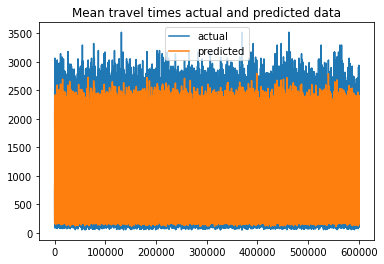

In [ ]:
x_ax = range(len(y_test))
plot.plot(x_ax, y_test, label="actual")
plot.plot(x_ax, predictions_grad2, label="predicted")

plot.title("Mean travel times actual and predicted data")

plot.legend()
plot.show()

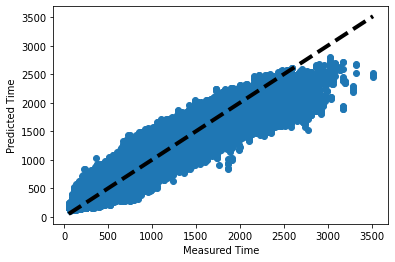

In [ ]:
fig, ax = plot.subplots()
ax.scatter(y_test, predictions_grad2)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured Time')
ax.set_ylabel('Predicted Time')
plot.show()

### 4.3.1 Live Testing

In [ ]:
features = ['Source lat', 'Source long', 'Dest lat', 'Dest long', 'dow', 'Geodesic Distance']
outcome = ['mean_travel_time']

def get_distance(lat1, long1, lat2, long2):
    src_point = (lat1, long1)
    dest_point = (lat2, long2)
    return geopy.distance.geodesic(src_point, dest_point).kilometers

def prepare_df(lat1, long1, lat2, long2, hod):
    distance = get_distance(lat1, long1, lat2, long2)
    return pd.DataFrame(columns = ['Source lat', 'Source long', 'Dest lat', 'Dest long', 'dow', 'Geodesic Distance'],
                 data = [[lat1, long1, lat2, long2, dow, distance]])
    
def predict(df):
    return my_model_6.predict(df[features])

In [ ]:
lat1 = 13.002385
long1 = 77.568491
lat2 = 13.061071
long2 = 77.597371
dow = 10

df = prepare_df(lat1, long1, lat2, long2, dow)
predict(df)

array([371.33895423])

##4.4 K-Nearest Neighbor (KNN) Regressor

In [41]:
from sklearn.neighbors import KNeighborsRegressor as knn

filename = 'knn_model.bin'
path = output_path + filename

if file_exists(path):
    with open(path, 'rb') as file:
        my_model_knn = pickle.load(file)
else:
    my_model_knn = knn(n_neighbors=7, leaf_size=30, weights='distance',p=1)
    my_model_knn.fit(X_train, y_train)
    
try:    
    save_object(X_train, output_path + 'train_set_x.bin')
    save_object(y_train, output_path + 'train_set_y.bin')
    save_object(X_test, output_path + 'test_set_x.bin')
    save_object(y_test, output_path + 'test_set_y.bin')
    save_object(my_model_knn, output_path + filename)
except:
    pass

Metrics Calculation

In [42]:
predictions_knn = my_model_knn.predict(X_test)

from sklearn import metrics

r2 = metrics.r2_score(y_test, predictions_knn)
print('R2: {}\n'.format(r2))

mse = metrics.mean_squared_error(y_test, predictions_knn)
print('MSE: {}\n'.format(mse))

print('RMSE: {}\n'.format(np.sqrt(mse)))

mae = metrics.mean_absolute_error(y_test, predictions_knn)
print('MAE: {}\n'.format(mae))

R2: 0.8569015640246431

MSE: 39117.69416384698

RMSE: 197.78193588861188

MAE: 149.80392672380046



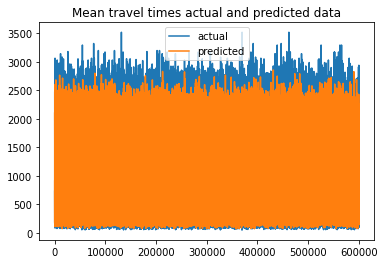

In [44]:
x_ax = range(len(y_test))
plot.plot(x_ax, y_test, label="actual")
plot.plot(x_ax, predictions_knn, label="predicted")

plot.title("Mean travel times actual and predicted data")

plot.legend()
plot.show()

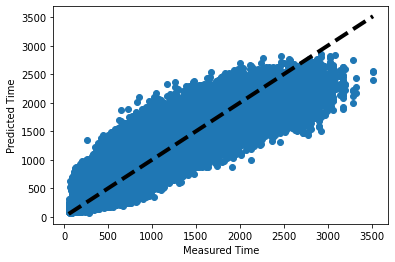

In [45]:
fig, ax = plot.subplots()
ax.scatter(y_test, predictions_knn)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured Time')
ax.set_ylabel('Predicted Time')
plot.show()

### 4.4.1 Live Testing

In [46]:
features = ['Source lat', 'Source long', 'Dest lat', 'Dest long', 'dow', 'Geodesic Distance']
outcome = ['mean_travel_time']

def get_distance(lat1, long1, lat2, long2):
    src_point = (lat1, long1)
    dest_point = (lat2, long2)
    return geopy.distance.geodesic(src_point, dest_point).kilometers

def prepare_df(lat1, long1, lat2, long2, hod):
    distance = get_distance(lat1, long1, lat2, long2)
    return pd.DataFrame(columns = ['Source lat', 'Source long', 'Dest lat', 'Dest long', 'dow', 'Geodesic Distance'],
                 data = [[lat1, long1, lat2, long2, dow, distance]])
    
def predict(df):
    return my_model_knn.predict(df[features])

In [47]:
lat1 = 13.002385
long1 = 77.568491
lat2 = 13.061071
long2 = 77.597371
dow = 10

df = prepare_df(lat1, long1, lat2, long2, dow)
predict(df)

array([[590.2408822]])

# 5. Conclusion

Based on all the models that we have made, it turns out that the Random Forest model has the highest R2 score of 0.9962675173602626 and the lowest error metrics score (MSE, RMSE, MAE). 
Thus, we conclude that our model with Random Forest Algorithm is the best model for ETA prediction.